# Lesson 2: Orbits and Time
In Lesson 1 we visualized the shape of an orbit using the polar orbit equation:

$$
r = \frac{a(1-e^2)}{1 + e\cos{\theta}}
$$

Where `a, e, theta` are the semi-major axis (orbit size), eccentricity (orbit shape), and true anomaly (where in the orbit we are).

We even included three other orbital elements `i, raan, argp` that orient the orbit plane in space to draw out the ground track on a map.

However we neglected one critical element that made our ground track wrong: __time__. Time does not appear anywhere in our function in Lesson 1, but it's really important.

In this lesson we're going to dive into how we get time into our orbit trajectory so that we can finally make an accurate ground track, among other things.

Get all of our imports and constants out of the way for later use:

In [1]:
import utilities_l2 as utils

import math
import matplotlib.pyplot as plt

RADIUS_EARTH = 6371008.0
MU_EARTH = 398600441500000.0
EARTH_ROTATION_RATE = -7.292123e-5
RADIAN_TO_DEGREE = 57.2957795131
DEGREE_TO_RADIAN = 0.01745329251

## 2.1 Eccentric and Mean Anomalies
Before we start talking about time, we need to introduce two more quantities:
- `E` the eccentric anomaly
- `M` the mean anomaly

These quantities are measured in radians just like true anomaly (`theta`). `E` has a geometric definition as an angle, but it doesn't really matter for our understanding.

`M` on the other hand is not strictly an angle, rather it's the fraction of an orbit's _period_ that has elapsed. `M` is how we're going to get to time, since we know the period (time for a full orbit) from the semi-major axis (`a`).

The relationships between the three anomalies and time are fairly straightforward equations:

$$
\tan{\frac{E}{2}} = \sqrt{\frac{1-e}{1+e}}\tan{\frac{\theta}{2}}
$$

$$
M = E - e\sin{E}
$$

$$
t = M\sqrt{\frac{a^3}{\mu}}
$$

That's a lot, so let's review all of the different quantities in these three equations:
- `t`: time, technically the time past perigee, but can be shifted easily
- `theta`: true anomaly, angle between perigee and current location in orbit
- `E`: eccentric anomaly, an irrelevant angle (for our purposes)
- `M`: mean anomaly, but fraction of an orbit period elapsed, express as an angle
- `e`: eccentricy, an orbital element
- `a`: semimajor axis, an orbital element
- `mu`: earth gravitational parameter (a constant)

### 2.1.1 Anomaly Conversion Functions

We're going to define three functions that implements the three equations above, convert from true anomaly (`theta`) to time (`t`) in steps. We'll then add a fourth function to stitch the steps together. Our three steps will be:

$$
\theta \rightarrow E \rightarrow M \rightarrow t
$$

If you want, replace each of the lines with `utils...` with your own implementation (reccomend against this for `true_anom_to_eccentric_anom` due to `atan` annoyances).

In [2]:
def true_anom_to_eccentric_anom(theta, e):
    E = utils.true_anom_to_eccentric_anom(theta, e)
    return E


def eccentric_anom_to_mean_anom(E, e):
    M = utils.eccentric_anom_to_mean_anom(E, e)
    return M


def mean_anom_to_time(M, a):
    t = utils.mean_anom_to_time(M, a)
    return t


def true_anom_to_time(theta, a, e):
    t = utils.true_anom_to_time(theta, a, e)
    return t

### 2.1.2 Plotting Anomolies
Let's plot true and mean anomaly against time (eccentric anomaly isn't critical to the discussion, it's more the middleman that gets us where we want to go).

How does changing `a` change the plot? Changing `e`?

Set `e` to a high value like `0.8`. Why is the slope of the `theta` lines so high at the beginning and end?

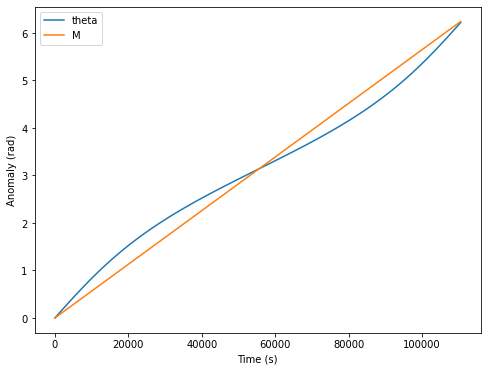

In [3]:
e = 0.2
a = 50000000

theta_list = []
E_list = []
M_list = []
t_list = []

N = 101 # number points to plot

for i in range(N):
    theta = i * 2 * math.pi / N
    E = true_anom_to_eccentric_anom(theta, e)
    M = eccentric_anom_to_mean_anom(E, e)
    t = mean_anom_to_time(M, a)
    
    theta_list.append(theta)
    E_list.append(E)
    M_list.append(M)
    t_list.append(t)
    
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

ax.plot(t_list, theta_list, label="theta")
ax.plot(t_list, M_list, label="M")

ax.set_xlabel("Time (s)")
ax.set_ylabel("Anomaly (rad)")
ax.legend()
plt.show()

## 2.2 Ground Track - Second Attempt
Amazingly, we have now enough done enough work to correct our orbit ground track from Lesson 1. This is a four step process:

1. Calculate the trajectory in inertial space just like we did in Lesson 1 and convert that trajectory to latitude/longitude coordinates. Nothing new here.
2. Calculate the elapsed time at each point in our trajectory using the conversion functions above.
3. Calculate how much the earth has rotated since `t=0`. The earth rotates at constant rate, so this isn't hard.
4. Shift the trajectory longitude value at each time step by however much the earth has rotated.
5. Plot!

Note: that Step 4 is kind of a hack, so you should not try rotations like this at home.

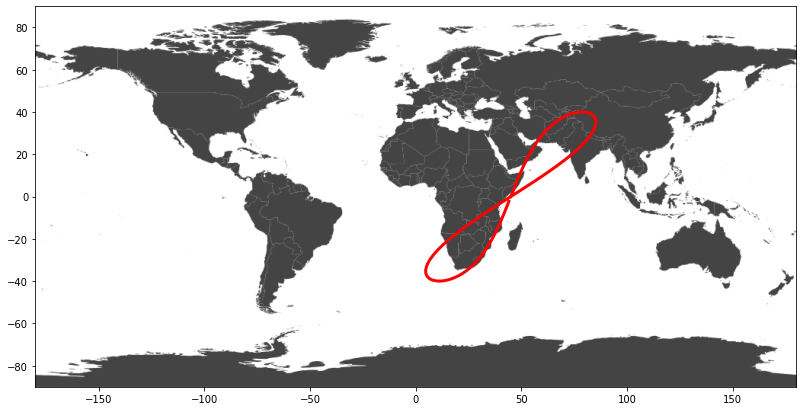

In [4]:
# variables you can change
a = 42166000
e = 0.3
i = 40 * DEGREE_TO_RADIAN
raan = 45 * DEGREE_TO_RADIAN
argp = 0 * DEGREE_TO_RADIAN
N = 101 # number of theta values to plot

# these are empty lists that we will append data to in the loop below
lat_list = []
lon_list = []

# the for loop steps through each value of theta
for j in range(N):
    theta = j * 2 * math.pi / N
    
    # step 1 - calculate x,y,z in inertial then lat/lon
    x, y, z, vx, vy, vz = utils.convert_kepler_to_cartesian(a, e, i, raan, argp, theta)
    lat, lon, alt = utils.convert_cartesian_to_lla(x, y, z)
    
    # step 2 - calculate elapsed time since start
    t = true_anom_to_time(theta, a, e)
    
    # step 3 - calculate earth rotation angle
    delta_lon = t * EARTH_ROTATION_RATE
    
    # step 4 - modify longitude by earth rotation angle
    lon = lon + delta_lon
    
    # make sure longitude falls in -pi,pi interval (i.e. -180, 180 deg)
    lon = (lon + math.pi) % (2 * math.pi) - math.pi
    
    lat_list.append(lat)
    lon_list.append(lon)
    
# step 5 - plot
ax = utils.add_latlon_trajectory(lat_list, lon_list)

## 2.3 Solving Keplers Equation

## 2.4 Orbit Propagation in Time

## 2.5 Equations of Motion

## 2.6 Simple Numerical Integration

## 2.7 Accurate Numerical Integration

## 2.8 Kepler or Integration?